In [1]:
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
import keras
from keras import Model, Input
from keras.layers import Conv1D, Flatten, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, roc_auc_score
from keras.callbacks import TensorBoard, ModelCheckpoint
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Preparing data**

In [2]:
# Creating labels
bird_labels = pd.read_csv("/kaggle/input/bird-song-data-set/bird_songs_metadata.csv", usecols=['species'])
bird_labels = bird_labels.values
bird_labels[bird_labels == ['bewickii']] = 0
bird_labels[bird_labels == ['polyglottos']] = 1
bird_labels[bird_labels == ['migratorius']] = 2
bird_labels[bird_labels == ['melodia']] = 3
bird_labels[bird_labels == ['cardinalis']] = 4
bird_labels = np.squeeze(bird_labels)

# Creating list of file paths
file_names = pd.read_csv("/kaggle/input/bird-song-data-set/bird_songs_metadata.csv", usecols=['filename'])
file_names = np.squeeze(file_names.values)
bird_filepaths = np.array([])
for file in file_names:
    bird_filepaths = np.append(bird_filepaths, '/kaggle/input/bird-song-data-set/wavfiles/'+file)

# Splitting data into training and validation set
bird_filepaths_train, bird_filepaths_val, bird_labels_train, bird_labels_val = train_test_split(
    bird_filepaths, bird_labels, test_size=0.10, random_state=2419)

# Function that reads filepaths
def read_file(path):
    y,_ = librosa.load(path)
    return y

# Converting to db scale
def spec_to_db(y):
    y_db = librosa.amplitude_to_db(y, ref=100)
    return y_db

# Map function that returns spectrograms
def map_function(path_tensor, label):
    y=tf.numpy_function(read_file, inp= [path_tensor], Tout = tf.float32)
    spectrogram = tf.abs(tf.signal.stft(y, frame_length=512, frame_step=64))
    spectrogram_db = tf.numpy_function(spec_to_db, inp = [spectrogram], Tout = tf.float32)
    spectrogram_db = spectrogram_db/80+1
    return spectrogram_db, label

# Function that creates tf.data.Dataset with shuffle, repeat, map and batch
def make_dataset(bird_labels, bird_filepaths, shuffle):
    bird_labels = tf.convert_to_tensor(bird_labels, dtype = tf.int32)
    bird_filepaths = tf.convert_to_tensor(bird_filepaths, dtype = tf.string)

    bird_labels = tf.data.Dataset.from_tensor_slices(bird_labels)
    bird_filepaths = tf.data.Dataset.from_tensor_slices(bird_filepaths)
    dataset = tf.data.Dataset.zip( bird_filepaths, bird_labels)

    if shuffle:
        dataset = dataset.shuffle(buffer_size = dataset.cardinality(), reshuffle_each_iteration=True)
    dataset = dataset.map(map_function, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size = 32, num_parallel_calls = tf.data.AUTOTUNE, drop_remainder = True)

    return dataset

In [3]:
dataset_train = make_dataset(bird_labels_train, bird_filepaths_train, shuffle=True)
dataset_val = make_dataset(bird_labels_val, bird_filepaths_val, shuffle=False)

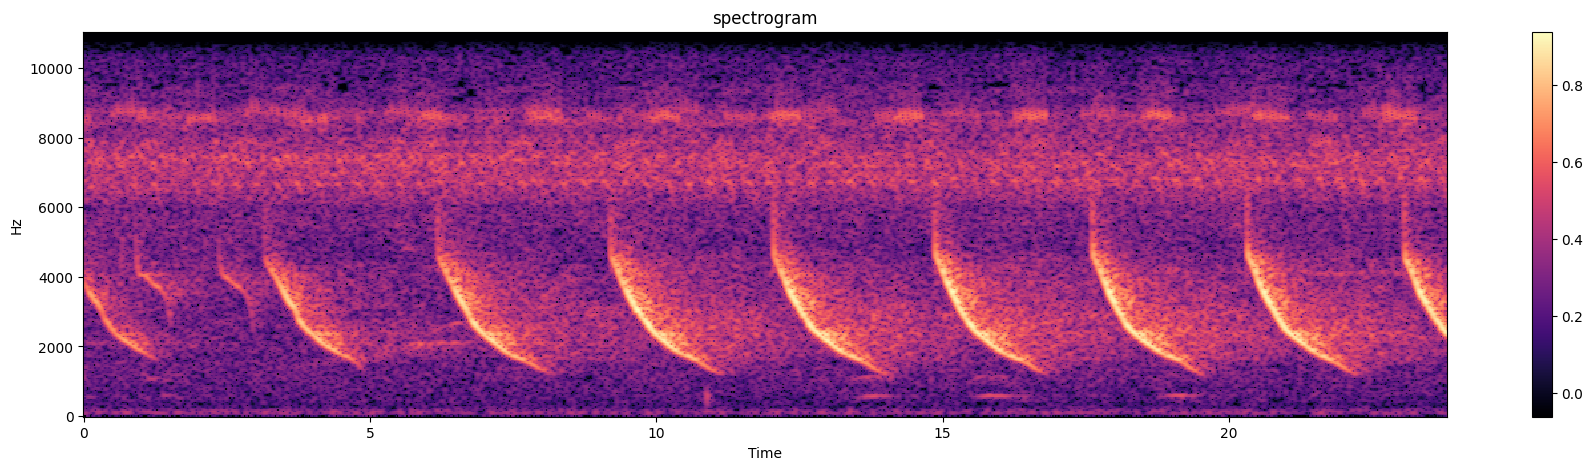

In [4]:
for spectrograms,labels in dataset_train:
    plt.figure(figsize=(22,5))
    librosa.display.specshow(spectrograms[0].numpy().T,y_axis='linear', x_axis='time', cmap = 'magma')
    plt.colorbar()
    plt.title('spectrogram')
    plt.show()
    break

**Creating model**

In [5]:
def create_model():
    inputs = Input((1026, 257), name = '0_Input_shape')

    x = Conv1D(128,8,2, activation='relu', padding='same', name = '1_Conv1D')(inputs)
    x = SpatialDropout1D(0.17, name = '2_SpatialDropout1D')(x)

    x = Conv1D(128,8,2, activation='relu', padding='same', name = '3_Conv1d')(x)
    x = SpatialDropout1D(0.17, name = '4_SpatialDropout1D')(x)

    x = Conv1D(128,8,2, activation='relu', padding='same', name = '5_Conv1d')(x)
    x = SpatialDropout1D(0.17, name = '6_SpatialDropout1D')(x)

    x = Conv1D(128,8,2, activation='relu', padding='same', name = '7_Conv1d')(x)
    x = SpatialDropout1D(0.17, name = '8_SpatialDropout1D')(x)

    x = GlobalAveragePooling1D(name = '9_Global_avg_pooling')(x)
    x = Dense(512, activation='relu', name='10_Dense')(x)
    x = Dropout(0.5, name='11_Dropout')(x)
    outputs = Dense(5, name='12_Dense')(x)
    model = Model(inputs=inputs, outputs=outputs, name = 'Bird_audio_classification_model')

    return model

In [6]:
model = create_model()
model.summary()

Model: "Bird_audio_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_Input_shape (InputLayer)  [(None, 1026, 257)]       0         
                                                                 
 1_Conv1D (Conv1D)           (None, 513, 128)          263296    
                                                                 
 2_SpatialDropout1D (Spatia  (None, 513, 128)          0         
 lDropout1D)                                                     
                                                                 
 3_Conv1d (Conv1D)           (None, 257, 128)          131200    
                                                                 
 4_SpatialDropout1D (Spatia  (None, 257, 128)          0         
 lDropout1D)                                                     
                                                                 
 5_Conv1d (Conv1D)           (None,

**Compiling model with learning rate schedule**

In [7]:
lr_schedule = ExponentialDecay(initial_learning_rate=1e-3,
                               decay_steps= 4000, decay_rate = 0.5, staircase=False, name=None)

model.compile(optimizer = Adam(lr_schedule),
              loss = SparseCategoricalCrossentropy(from_logits = True),
              metrics = [ SparseCategoricalAccuracy()])

**Creating callbacks**

In [8]:
# Creating callbacks
logdir = 'tb_logs/model'
tensorboard_callback = TensorBoard(log_dir=logdir)

checkpoint_filepath = 'model_checkpoint/model'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

**Training model**

In [9]:
training = model.fit(dataset_train, validation_data = dataset_val, epochs=120, callbacks=[tensorboard_callback,model_checkpoint_callback])

Epoch 1/120
152/152 [==============================] - 45s 269ms/step - loss: 1.4356 - sparse_categorical_accuracy: 0.3267 - val_loss: 1.2463 - val_sparse_categorical_accuracy: 0.3652
Epoch 2/120
152/152 [==============================] - 42s 275ms/step - loss: 1.2506 - sparse_categorical_accuracy: 0.4001 - val_loss: 1.2209 - val_sparse_categorical_accuracy: 0.4395
Epoch 3/120
152/152 [==============================] - 40s 265ms/step - loss: 1.2237 - sparse_categorical_accuracy: 0.4576 - val_loss: 1.1587 - val_sparse_categorical_accuracy: 0.4512
Epoch 4/120
152/152 [==============================] - 41s 266ms/step - loss: 1.1254 - sparse_categorical_accuracy: 0.4879 - val_loss: 1.0070 - val_sparse_categorical_accuracy: 0.5605
Epoch 5/120
152/152 [==============================] - 41s 266ms/step - loss: 1.0602 - sparse_categorical_accuracy: 0.5374 - val_loss: 0.9614 - val_sparse_categorical_accuracy: 0.5762
Epoch 6/120
152/152 [==============================] - 41s 269ms/step - loss: 1.

**Evaluating model on validation dataset**
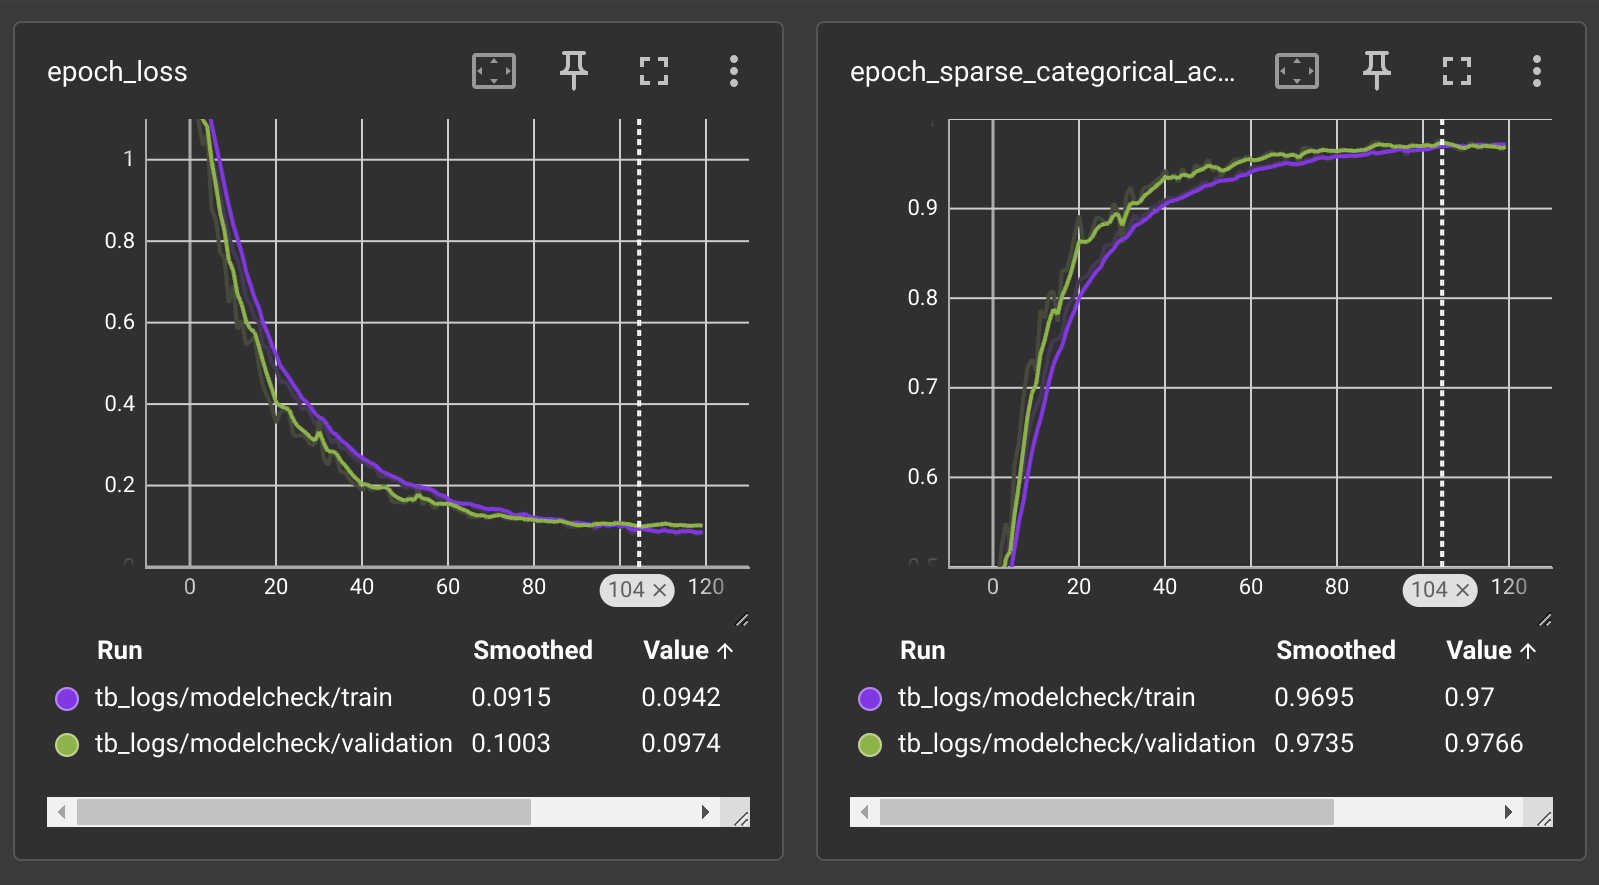

**Model training is slow so I uploaded a pretrained model**

In [10]:
model.evaluate(dataset_val, return_dict=True)

16/16 [==============================] - 4s 222ms/step - loss: 0.1084 - sparse_categorical_accuracy: 0.9688


{'loss': 0.10842221230268478, 'sparse_categorical_accuracy': 0.96875}

In [11]:
y_logits = model.predict(dataset_val)
y_prob = tf.nn.softmax(y_logits, axis=1)
y_pred = tf.argmax(y_logits, axis=1)
y_true = tf.concat(list(dataset_val.map(lambda s,lab: lab)), axis=0)

16/16 [==============================] - 4s 219ms/step


In [12]:
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
auc = roc_auc_score(y_true, y_prob, average='macro', multi_class='ovo')
print(f"F1: {f1} | Precision: {precision} | Recall: {recall} | AUC: {auc}")

F1: 0.9695986783963377 | Precision: 0.9689407969552253 | Recall: 0.9704567701816454 | AUC: 0.9980569031259439


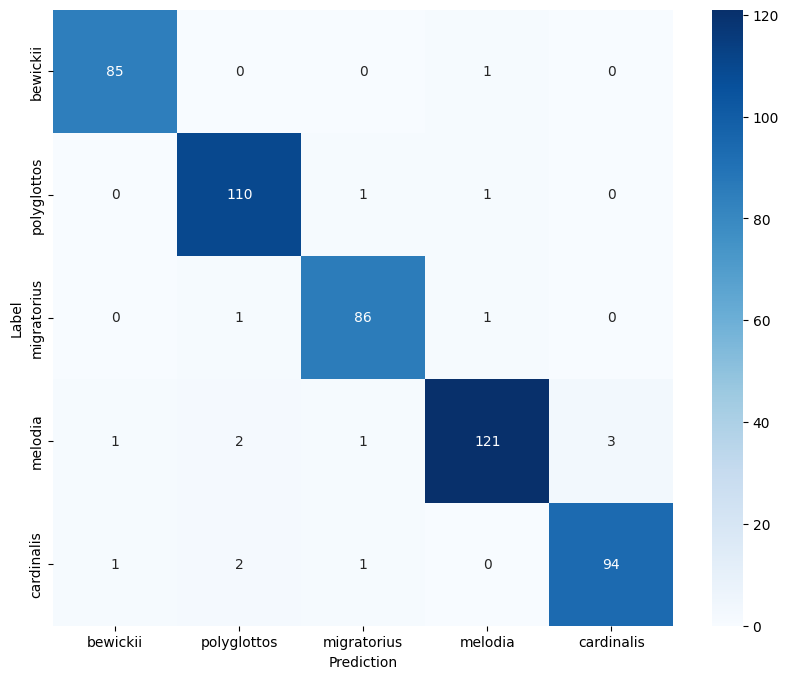

In [13]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            yticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            annot=True, fmt='g', cmap = 'Blues')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [15]:
model.save("model.keras")

In [2]:
import keras
keras.__version__

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'2.13.1'